# Libraries

In [2]:
# import basic libraries
import numpy as np
import pandas as pd

# import reading/writing libraries
import os
from google.colab import drive   # mounting google drive
drive.mount('/content/drive')

# import reading/writing libraries necessary for up/downloading from local computer
from google.colab import files
import io

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()
from mpl_toolkits.mplot3d import Axes3D

# date tools
from dateutil.relativedelta import relativedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Regression Tools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from fbprophet import Prophet

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import plot_importance, plot_tree

# deep learning tools
import tensorflow as tf
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Data

In [0]:
# import from a local drive
# uploaded = files.upload()
# dataset = pd.read_excel(io.BytesIO(uploaded['D202.xlsx']))


# import directly from Google Drive
dataset = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Inputs/D202.xlsx')


**Data Description:**
 - Data Shape (70368 , 8)
 - Columns (Type, Date, Start Time, End Time, Usage, Units, Cost, Notes)
 - Columns ```Type``` and ```Units``` have only one value (Electric usage and kWh, respectively) and can be simply dropped. 

**Exploring Missing Values:**
 - Column ```Notes``` is empty and can be dropped.

In [0]:
dataset = dataset.drop(['TYPE', 'UNITS', 'NOTES'], axis=1)  # dropping TYPE, UNITS, and NOTES. Having no useful info. 

# Feature Extraction

In this section, the possible useful date and hour features are extracted from the existing data.  

In [5]:
def create_features(df):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['day'] = df['DATE'].dt.day # day of month
    df['dayofweek'] = df['DATE'].dt.dayofweek
    df['quarter'] = df['DATE'].dt.quarter
    df['month'] = df['DATE'].dt.month
    df['year'] = df['DATE'].dt.year
    df['dayofyear'] = df['DATE'].dt.dayofyear
    df['weekofyear'] = df['DATE'].dt.weekofyear
    df['week'] = df['DATE'].dt.week # similar to weekofyear
    df['is_month_end']=df['DATE'].dt.is_month_end
    df['is_month_start']=df['DATE'].dt.is_month_start
    df['is_year_end']=df['DATE'].dt.is_year_end
    df['is_year_start']=df['DATE'].dt.is_year_start

    df['start_time'] = pd.to_datetime(df['START TIME'], format='%H:%M:%S')
    df['hour'] = df['start_time'].dt.hour
    df['minute'] = df['start_time'].dt.minute

    # federal holidays
    cal = calendar()
    holidays = cal.holidays(start=df['DATE'].min(), end=df['DATE'].max())
    df['is_holiday'] = df['DATE'].isin([d.date() for d in cal.holidays()])

    # Create a column for datetime
    df['DateTime'] = pd.to_datetime(df[['year','month','day', 'hour', 'minute']])

    # order of granularity : 1. minute, 2. hour, 3.a. dayofweek, 3.b. dayofmonth, 4. weekofyear
    # 5. month 6. quarter 7. year

    X = df[['DateTime', 'hour', 'minute', 'dayofweek', 'day', 'weekofyear', 'month', 'quarter', 'year', 'is_holiday']]
     
    # one hot encoding
    one_hot_features = ['hour', 'dayofweek', 'weekofyear', 'month', 'quarter']
    for feature in one_hot_features:
      X = pd.concat([X, pd.get_dummies(df[feature], prefix=feature)], axis=1)
    

    return X, holidays


X, holidays = create_features(dataset) 
y = dataset['USAGE'] #labels = USAGE and COST

features_and_target = pd.concat([X, y], axis=1)

# drop duplicates
features_and_target.drop_duplicates(subset = 'DateTime', keep='first', inplace=True)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [0]:
# picking a specific time frequency (hourly, daily, etc) 
freq_index = pd.date_range(start=features_and_target['DateTime'].min(), end=features_and_target['DateTime'].max(), freq='H')  # hourly
# freq_index = pd.date_range(start=features_and_target['DateTime'].min(), end=features_and_target['DateTime'].max(), freq='D')  # daily
features_and_target_hourly = features_and_target[features_and_target['DateTime'].isin(freq_index)] 


## Visualization for exploration

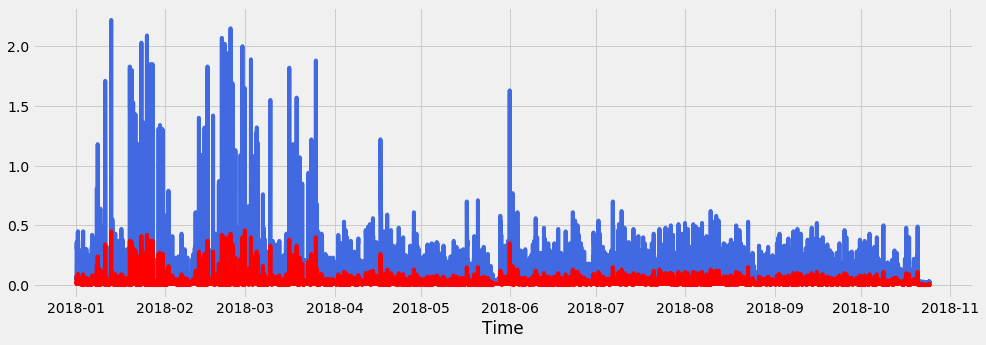

correlation b/w USAGE and COST is           USAGE      COST
USAGE  1.000000  0.991939
COST   0.991939  1.000000


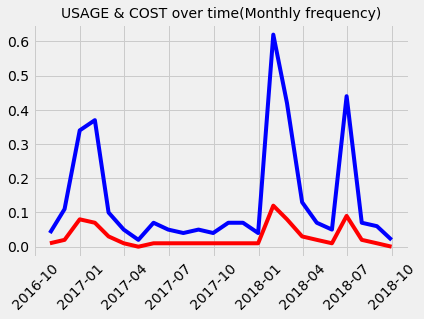

In [18]:
# Compare electricity USAGE and COST for different years
df1 = features_and_target
df2 = pd.concat([X, dataset['COST']], axis=1)
df2.drop_duplicates(subset = 'DateTime', keep='first', inplace=True)

YEAR = 2018  # 2016 (partial), 2017, 2018
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.plot(df1.loc[df1['year'] == YEAR, 'DateTime'],
         df1.loc[df1['year'] == YEAR, 'USAGE'], color='royalblue')
axs.plot(df2.loc[df2['year'] == YEAR, 'DateTime'],
         df2.loc[df2['year'] == YEAR, 'COST'], color='red')
axs.set_xlabel('Time')
# axs.set_ylabel('USAGE_kW')
plt.show()

## print the correlation b/w USAGE and COST
newdf = pd.DataFrame(df1.USAGE)
newdf['COST'] = df2.COST
newdf.index = df2.DateTime
print(f'correlation b/w USAGE and COST is {newdf.corr(method="pearson")}')
# result: USAGE and COST has 0.991 correlation.

plt.plot(newdf['COST'].asfreq('M'), color = 'red')
plt.plot(newdf['USAGE'].asfreq('M'), color = 'blue') # asfreq method is used to convert a time series to a specified frequency. Here it is monthly frequency.
plt.title('USAGE & COST over time(Monthly frequency)', size = 14)
plt.xticks(rotation=45)
plt.show()

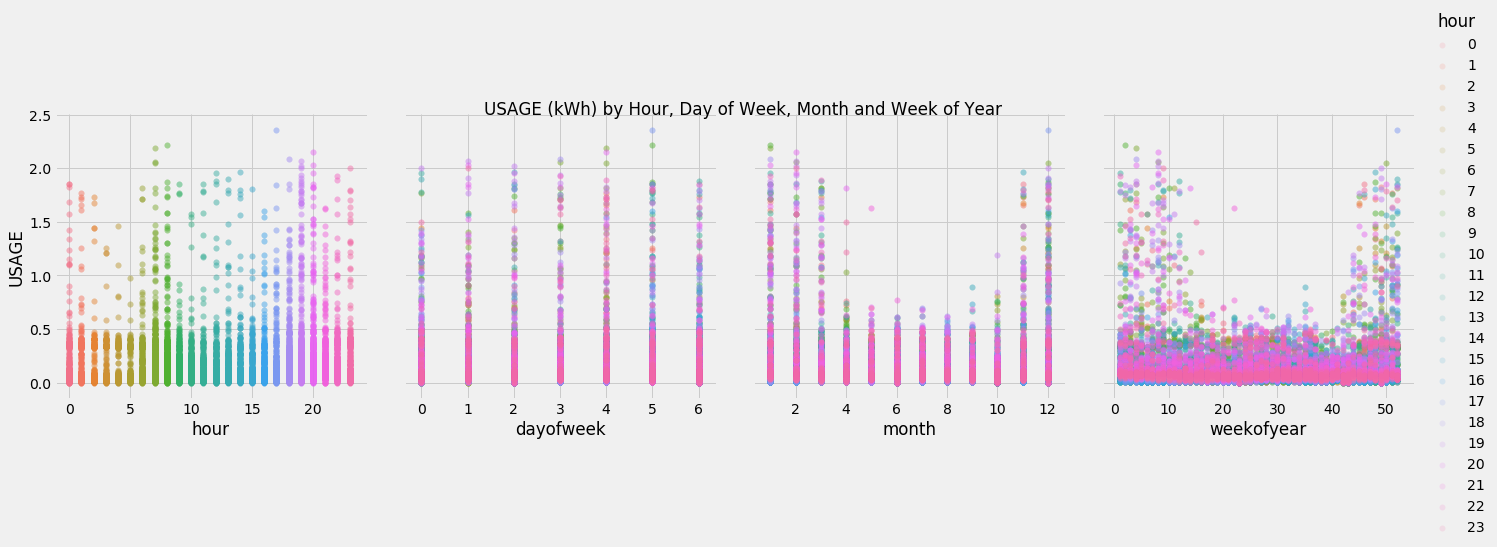

In [19]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'month','weekofyear'],
             y_vars='USAGE',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('USAGE (kWh) by Hour, Day of Week, Month and Week of Year')
plt.show()

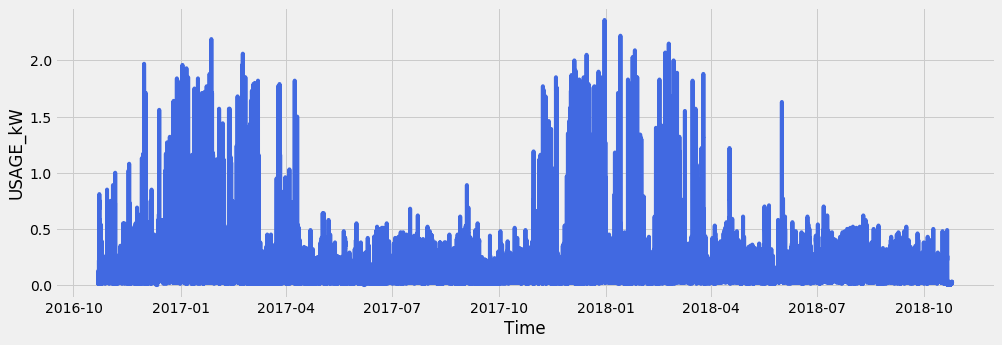

In [20]:
# plot energy consumption for the entire period of data
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.plot(features_and_target['DateTime'], features_and_target['USAGE'], color='royalblue')
axs.set_xlabel('Time')
axs.set_ylabel('USAGE_kW')
plt.show()

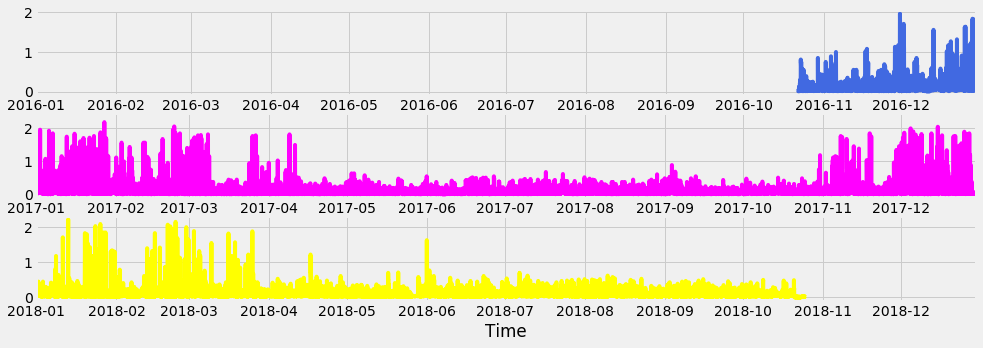

In [97]:
# plot electricity consumption for different years
YEAR = 2018  # 2016 (partial), 2017, 2018
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 5))
ax1.plot(features_and_target.loc[features_and_target['year'] == 2016, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2016, 'USAGE'], color='royalblue')
ax2.plot(features_and_target.loc[features_and_target['year'] == 2017, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2017, 'USAGE'], color='magenta')
ax3.plot(features_and_target.loc[features_and_target['year'] == 2018, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2018, 'USAGE'], color='yellow')
ax1.set_xlim(left=pd.datetime(2016,1,1), right=pd.datetime(2016,12,30))
ax2.set_xlim(left=pd.datetime(2017,1,1), right=pd.datetime(2017,12,30))
ax3.set_xlim(left=pd.datetime(2018,1,1), right=pd.datetime(2018,12,30))
# ax2.set_ylabel('USAGE_kW')
ax3.set_xlabel('Time')
plt.show()

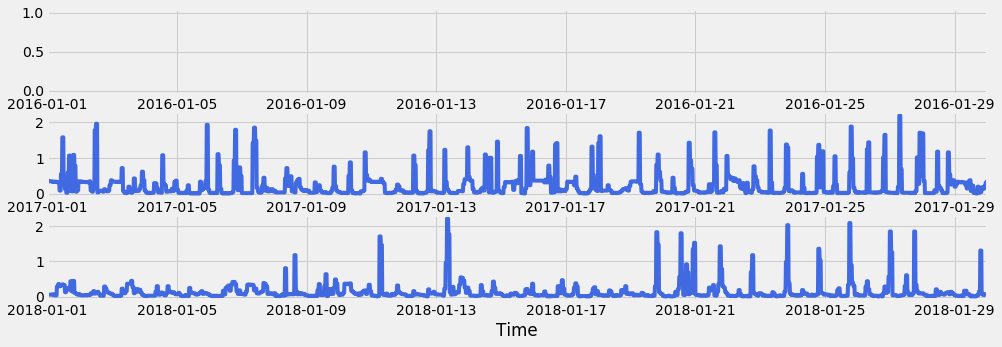

In [48]:
# plot energy consumption for different years and months
YEAR = 2017  # 2016 (partial), 2017, 2018
MONTH = 1    # pick a month b/w 1 to 12
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 5))
ax1.plot(features_and_target.loc[(features_and_target['year'] == 2016) & (features_and_target['month'] == MONTH), 'DateTime'],
         features_and_target.loc[(features_and_target['year'] == 2016) & (features_and_target['month'] == MONTH), 'USAGE'], color='royalblue')
ax2.plot(features_and_target.loc[(features_and_target['year'] == 2017) & (features_and_target['month'] == MONTH), 'DateTime'],
         features_and_target.loc[(features_and_target['year'] == 2017) & (features_and_target['month'] == MONTH), 'USAGE'], color='royalblue')
ax3.plot(features_and_target.loc[(features_and_target['year'] == 2018) & (features_and_target['month'] == MONTH), 'DateTime'],
         features_and_target.loc[(features_and_target['year'] == 2018) & (features_and_target['month'] == MONTH), 'USAGE'], color='royalblue')
ax1.set_xlim(left=pd.datetime(2016,MONTH,1), right=pd.datetime(2016,MONTH,30))
ax2.set_xlim(left=pd.datetime(2017,MONTH,1), right=pd.datetime(2017,MONTH,30))
ax3.set_xlim(left=pd.datetime(2018,MONTH,1), right=pd.datetime(2018,MONTH,30))
ax3.set_xlabel('Time')
# ax2.set_ylabel('USAGE_kW')
plt.show()

# Train/Test split

In [103]:
## Train/Test Split

# Initial to_drop list
to_drop = ['DateTime', 'hour', 'dayofweek', 'weekofyear', 'month', 'quarter'] # define columns to be dropped
# trap_avoidance = ['Dayofweek_0', 'Month_12', 'Quarter_4']  # define columns to be droped to avoid trap
# to_drop = to_drop.append(trap_avoidance)

eval_from = features_and_target['DateTime'].max() #+ relativedelta(months=-3)  # Here we set the 6 months threshold
###

train_df = features_and_target[features_and_target['DateTime'] <= eval_from]
valid_df = features_and_target[features_and_target['DateTime'] >  eval_from]

X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]

X_valid = valid_df.iloc[:,:-1]
y_valid = valid_df.iloc[:,-1]

print(f"Train data: {train_df['DateTime'].min()} -> {train_df['DateTime'].max()} | {len(train_df)} samples.")
print(f"Valid data: {valid_df['DateTime'].min()} -> {valid_df['DateTime'].max()} | {len(valid_df)} samples.")

Train data: 2016-10-22 00:00:00 -> 2018-10-24 23:45:00 | 70360 samples.
Valid data: NaT -> NaT | 0 samples.


In [124]:
## creating a test file
features_and_target['DateTime'].max() # finding the endpoint of training dataset Timestamp('2018-10-24 23:45:00')

# creating an index range from the end of training set to the end of year 2018
ix_frc = pd.DatetimeIndex(start=pd.datetime(2018, 10, 25), end=pd.datetime(2018, 12, 31), freq='0.25H')
ix_y18 = pd.DatetimeIndex(start=pd.datetime(2018, 1, 1), end=pd.datetime(2018, 12, 31), freq='0.25H')

oos_df = pd.DataFrame(index=ix_y18)
oos_df['DATE'] = oos_df.index
oos_df['START TIME'] = oos_df.index

oos_df, holidays = create_features(oos_df)

oos_df = oos_df[oos_df.index.isin(ix_frc)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



# Modeling

## ARIMA

Since the data is not **stationary** (by stationary I mean that the properties of the series doesn't depend on the time when it is captured.) ARIMA model does not yield a good result. So, this method is not used. 


## Gradient Boosting Regressor

In [104]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [5],
    'max_features': [int(np.sqrt(train_df.shape[1]))]
}

# Create a based model
gb = GradientBoostingRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train.drop(columns=to_drop).values, y_train.values)
model = grid_search.best_estimator_

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  6.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  6.5min finished


In [297]:
print('\n')
print('learning_rate        : '+str(model.learning_rate)+'\n'+
      'n_estimators         : '+str(model.n_estimators)+'\n'+
      'max_depth            : '+str(model.max_depth)+'\n'+
      'min_samples_split    : '+str(model.min_samples_split)+'\n'+
      'min_samples_leaf     : '+str(model.min_samples_leaf)+'\n'+
      'max_features         : '+str(model.max_features))

print('\n')
print( np.sqrt(mean_squared_error(y_train.values, model.predict(X_train.drop(columns=to_drop).values))) )
print( r2_score(y_train.values, model.predict(X_train.drop(columns=to_drop).values)) )

# without holidays
# mse: 0.167
# r^2: 0.361

print('\n')
print( np.sqrt(mean_squared_error(y_valid.values, model.predict(X_valid.drop(columns=to_drop).values))) )
print( r2_score(y_valid.values, model.predict(X_valid.drop(columns=to_drop).values)) )
print('\n')

# without holidays
# mse: 0.216
# r^2: -0.05



learning_rate        : 0.1
n_estimators         : 1000
max_depth            : 10
min_samples_split    : 5
min_samples_leaf     : 5
max_features         : 10


0.06323876432647292
0.9090612004024842


0.2345386459364987
-0.2319539833023745




In [0]:
y_pred = model.predict(oos_df.drop(columns=to_drop))
forecast_df = oos_df
forecast_df['USAGE'] =y_pred           

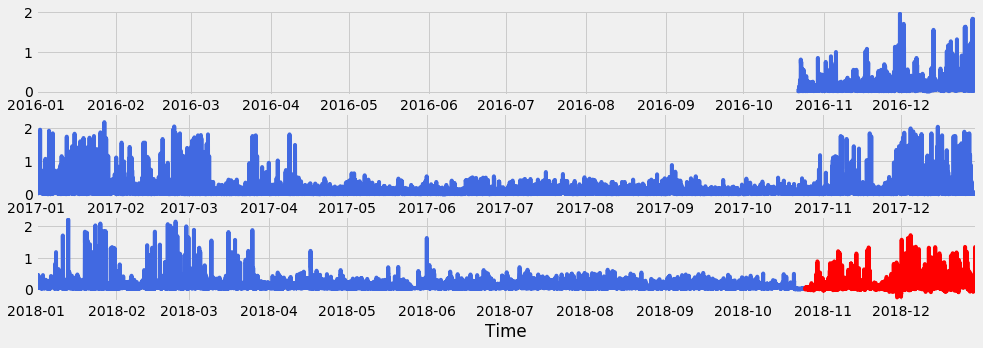

In [120]:
# plot electricity consumption for different years
YEAR = 2018  # 2016 (partial), 2017, 2018
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 5))
ax1.plot(features_and_target.loc[features_and_target['year'] == 2016, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2016, 'USAGE'], color='royalblue')
ax2.plot(features_and_target.loc[features_and_target['year'] == 2017, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2017, 'USAGE'], color='royalblue')
ax3.plot(features_and_target.loc[features_and_target['year'] == 2018, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2018, 'USAGE'], color='royalblue')
ax3.plot(forecast_df.loc[forecast_df['year'] == 2018, 'DateTime'],
         forecast_df.loc[forecast_df['year'] == 2018, 'USAGE'], color='red')
ax1.set_xlim(left=pd.datetime(2016,1,1), right=pd.datetime(2016,12,30))
ax2.set_xlim(left=pd.datetime(2017,1,1), right=pd.datetime(2017,12,30))
ax3.set_xlim(left=pd.datetime(2018,1,1), right=pd.datetime(2018,12,30))
# ax2.set_ylabel('USAGE_kW')
ax3.set_xlabel('Time')
plt.show()

## XGBoost

In [121]:
# training the model with XGBoost
xg_trn_data = xgb.DMatrix(X_train.drop(columns=to_drop), label=y_train)
xg_vld_data = xgb.DMatrix(X_valid.drop(columns=to_drop), label=y_valid)

## parameters 
num_round = 300
xgb_param = {"objective": "reg:squarederror", 'eta': 0.1, 'booster': 'gbtree', 'max_depth': 10}

bst = xgb.train(params = xgb_param, dtrain = xg_trn_data, num_boost_round = num_round)

print('\n')
print( 'training dataset R^2: ', np.sqrt(mean_squared_error(y_train.values, bst.predict(xg_trn_data))) )
print( 'training dataset R^2: ', r2_score(y_train.values, bst.predict(xg_trn_data)))

# mse : 0.1773881776292423
# r^2 : 0.28989473658859655
# decision: weaker than Gradient Boosting

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version





training dataset R^2:  0.051205401298476734
training dataset R^2:  0.940834837879341


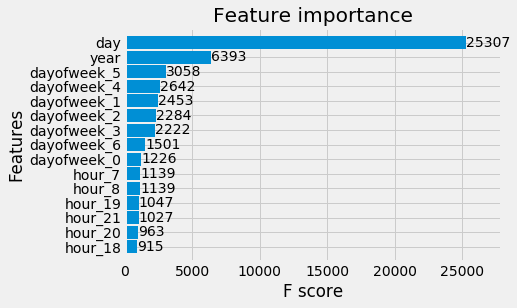

In [122]:
# plot feature importance
_ = plot_importance(bst, height=0.9, max_num_features=15)

In [0]:
# prediction

print('\n')
print( 'validation dataset MSE: ', np.sqrt(mean_squared_error(y_valid.values, bst.predict(xg_vld_data))) )
print( 'validation dataset R^2: ', r2_score(y_valid.values, bst.predict(xg_vld_data)))

In [0]:
xg_frc_data = xgb.DMatrix(oos_df.drop(columns=to_drop), label=None)
y_pred = bst.predict(xg_frc_data)
forecast_df = oos_df
forecast_df['USAGE'] =y_pred           

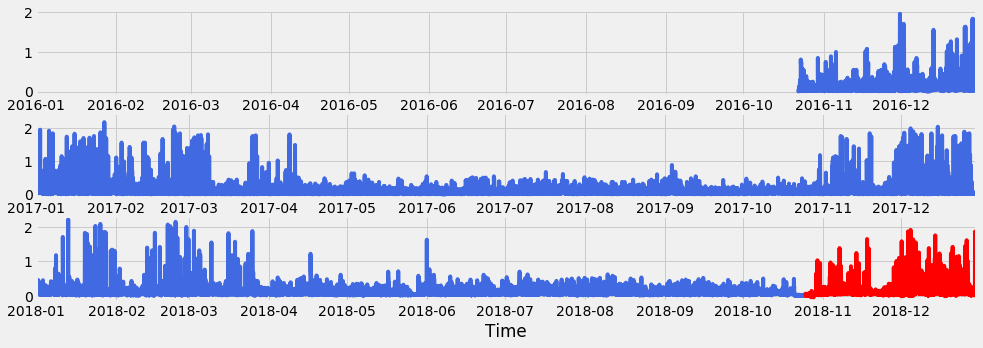

In [126]:
# plot electricity consumption for different years
YEAR = 2018  # 2016 (partial), 2017, 2018
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 5))
ax1.plot(features_and_target.loc[features_and_target['year'] == 2016, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2016, 'USAGE'], color='royalblue')
ax2.plot(features_and_target.loc[features_and_target['year'] == 2017, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2017, 'USAGE'], color='royalblue')
ax3.plot(features_and_target.loc[features_and_target['year'] == 2018, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2018, 'USAGE'], color='royalblue')
ax3.plot(forecast_df.loc[forecast_df['year'] == 2018, 'DateTime'],
         forecast_df.loc[forecast_df['year'] == 2018, 'USAGE'], color='red')
ax1.set_xlim(left=pd.datetime(2016,1,1), right=pd.datetime(2016,12,30))
ax2.set_xlim(left=pd.datetime(2017,1,1), right=pd.datetime(2017,12,30))
ax3.set_xlim(left=pd.datetime(2018,1,1), right=pd.datetime(2018,12,30))
# ax2.set_ylabel('USAGE_kW')
ax3.set_xlabel('Time')
plt.show()

## Prophet model

In [0]:
# Prophet model expects the dataset to be named a specific way. 
# We will rename our dataframe columns before feeding it into the model.
pdf_train = train_df[['DateTime','USAGE']].rename(columns={'DateTime':'ds', 'USAGE':'y'})
pdf_valid = valid_df[['DateTime','USAGE']].rename(columns={'DateTime':'ds', 'USAGE':'y'})

In [130]:
# Setup and train model and fit
holidays_df = pd.DataFrame()
holidays_df['ds'] = holidays
holidays_df['holiday'] = 'USFederalHoliday'
model = Prophet(holidays=holidays_df)
model.fit(pdf_train)

In [0]:
# Predict on training set with model
# prediction = model.predict(pdf_valid)

pdf_frc = oos_df[['DateTime']].rename(columns={'DateTime':'ds'})
forecast = model.predict(pdf_frc)

In [0]:
forecast_df = oos_df
forecast_df['USAGE'] = np.array(forecast['yhat'])   

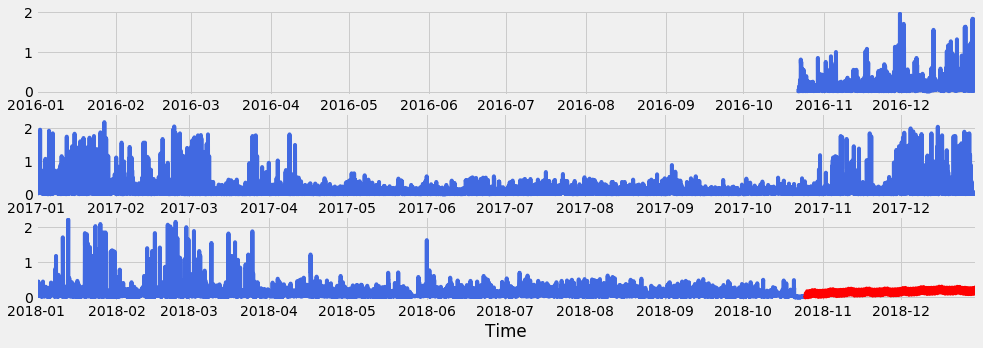

In [143]:
# plot electricity consumption for different years
YEAR = 2018  # 2016 (partial), 2017, 2018
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 5))
ax1.plot(features_and_target.loc[features_and_target['year'] == 2016, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2016, 'USAGE'], color='royalblue')
ax2.plot(features_and_target.loc[features_and_target['year'] == 2017, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2017, 'USAGE'], color='royalblue')
ax3.plot(features_and_target.loc[features_and_target['year'] == 2018, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2018, 'USAGE'], color='royalblue')
ax3.plot(forecast_df.loc[forecast_df['year'] == 2018, 'DateTime'],
         forecast_df.loc[forecast_df['year'] == 2018, 'USAGE'], color='red')
ax1.set_xlim(left=pd.datetime(2016,1,1), right=pd.datetime(2016,12,30))
ax2.set_xlim(left=pd.datetime(2017,1,1), right=pd.datetime(2017,12,30))
ax3.set_xlim(left=pd.datetime(2018,1,1), right=pd.datetime(2018,12,30))
# ax2.set_ylabel('USAGE_kW')
ax3.set_xlabel('Time')
plt.show()

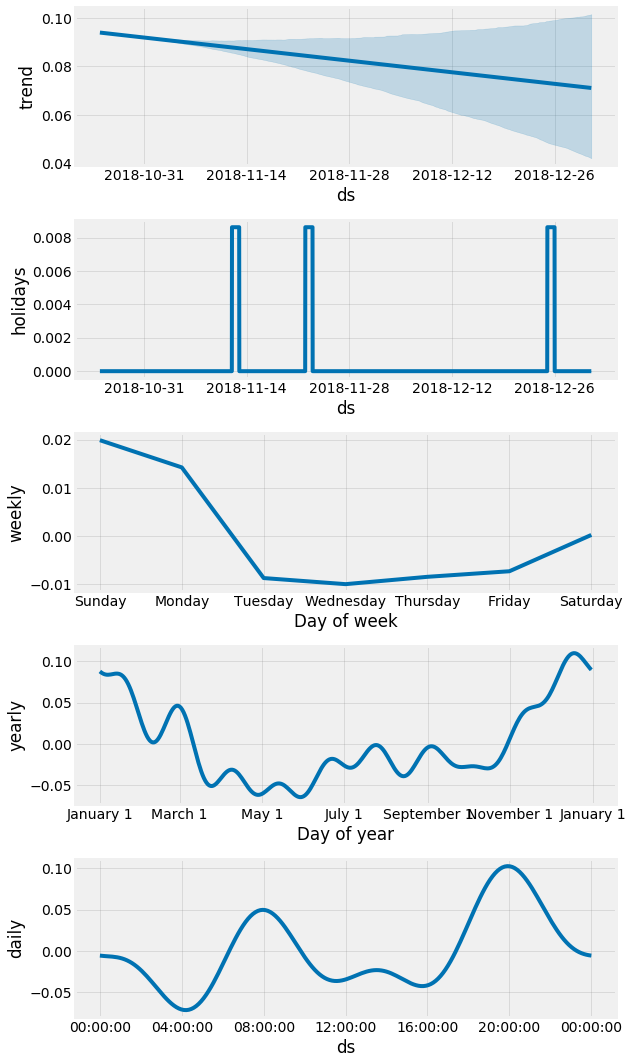

In [144]:
# Plot the components of the model
fig = model.plot_components(forecast)

In [263]:
# Evaluation
mse = mean_squared_error(y_true=valid_df['USAGE'], y_pred=prediction['yhat'])
mae = mean_absolute_error(y_true=valid_df['USAGE'], y_pred=prediction['yhat'])
print(f'mean squared error : {mse:.5f}')
print(f'mean absolute error : {mae:.5f}')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    MAPE = (sum(np.abs(y_true - y_pred)) / sum(y_true)) * 100
    return MAPE

mape = mean_absolute_percentage_error(y_true=valid_df['USAGE'], y_pred=prediction['yhat'])
print(f'mean absolute error : {mape:.5f}')

# accuracy without holidays
# mean squared error : 0.05648
# mean absolute error : 0.12837
# mean absolute error : 104.92418

mean squared error : 0.05772
mean absolute error : 0.13308
mean absolute error : 108.77373


## RNN

Both RNN and LSTM, similar to ARIMA methods, are only suitable for predicting the next period point. They generally can follow the trend of the signal (subject to a lot of assumptions). 

In [156]:
## prepare the dataset to be loaded into the RNN model 
RNN_df = pd.DataFrame(features_and_target['USAGE'])
RNN_df.index = features_and_target['DateTime']

# sequence length
# 1 day = 96 rows
# 1 week  = 672 rows
# 1 month = 2880 rows


def load_data(stock, seq_len, tailpoints):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 2880 rows are going to be used in test
    cut_off = stock.shape[0] - tailpoints
    X_test = X_train[cut_off:]             
    y_test = y_train[cut_off:]
    
    #2 first 67516 days are going to be used in training
    X_train = X_train[:cut_off]           
    y_train = y_train[:cut_off]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (cut_off, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

#create train, test data
seq_len = 96 #choose sequence length
tailpoints = 96 # minimum it must be equal to seq_len

X_train, y_train, X_test, y_test = load_data(RNN_df, seq_len, tailpoints)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

# X_train.shape =  (67516, 96, 1)
# y_train.shape =  (67516,)
# X_test.shape =  (2748, 96, 1)
# y_test.shape =  (2748,)

X_train.shape =  (70264, 96, 1)
y_train.shape =  (70264,)
X_test.shape =  (0, 96, 1)
y_test.shape =  (0,)


In [200]:
# create RNN model
rnn_model = Sequential()

# First layer : Fully Connected RNN
rnn_model.add(SimpleRNN(96*2, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

# Second layer : Fully Connected RNN
rnn_model.add(SimpleRNN(96*2,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

# Third layer : Fully Connected RNN
rnn_model.add(SimpleRNN(96*2,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

# Fourth layer : Fully Connected layer
rnn_model.add(Dense(1))

# rnn_model.summary()

# Compile the model 
rnn_model.compile(optimizer="adam", loss="MSE")

# Fit to the data
rnn_model.fit(X_train, y_train, epochs=5, batch_size=1000)

Epoch 1/5
70264/70264 [==============================] - 248s 4ms/step - loss: 0.3593
Epoch 2/5
70264/70264 [==============================] - 245s 3ms/step - loss: 0.1384
Epoch 3/5
70264/70264 [==============================] - 245s 3ms/step - loss: 0.0873
Epoch 4/5
70264/70264 [==============================] - 244s 3ms/step - loss: 0.0542
Epoch 5/5
70264/70264 [==============================] - 244s 3ms/step - loss: 0.0357


In [33]:
# predictoin
y_pred = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,y_pred)
print("R2 Score of RNN model = ",rnn_score)
# R2 Score of RNN model =  0.7732229252821089

R2 Score of RNN model =  0.7732229252821089


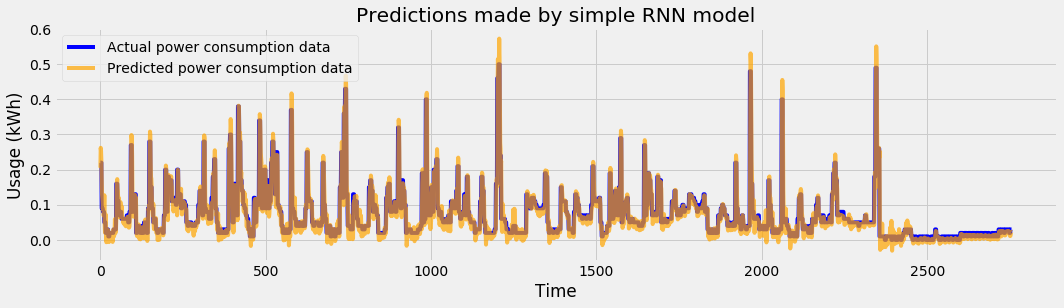

In [35]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Usage (kWh)')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, y_pred, "Predictions made by simple RNN model")

In [0]:
# rolling forecast 
lastsequence = np.reshape(X_train[70263],(1,96,1))

frc_result = []
for i in range(6433):
  nextpointfrc = rnn_model.predict(lastsequence)
  x = np.append(lastsequence[0][1:], nextpointfrc)
  lastsequence = np.reshape(x,(1,96,1))
  frc_result.append(nextpointfrc)

In [0]:
forecast_df = oos_df
forecast_df['USAGE'] = np.ravel(np.array(frc_result))

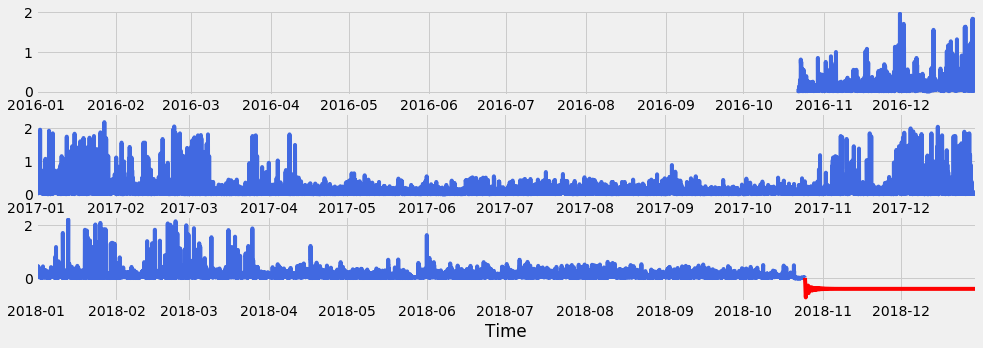

In [203]:
# plot electricity consumption for different years
YEAR = 2018  # 2016 (partial), 2017, 2018
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 5))
ax1.plot(features_and_target.loc[features_and_target['year'] == 2016, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2016, 'USAGE'], color='royalblue')
ax2.plot(features_and_target.loc[features_and_target['year'] == 2017, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2017, 'USAGE'], color='royalblue')
ax3.plot(features_and_target.loc[features_and_target['year'] == 2018, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2018, 'USAGE'], color='royalblue')
ax3.plot(forecast_df.loc[forecast_df['year'] == 2018, 'DateTime'],
         forecast_df.loc[forecast_df['year'] == 2018, 'USAGE'], color='red')
ax1.set_xlim(left=pd.datetime(2016,1,1), right=pd.datetime(2016,12,30))
ax2.set_xlim(left=pd.datetime(2017,1,1), right=pd.datetime(2017,12,30))
ax3.set_xlim(left=pd.datetime(2018,1,1), right=pd.datetime(2018,12,30))
# ax2.set_ylabel('USAGE_kW')
ax3.set_xlabel('Time')
plt.show()

## LSTM

In [204]:
# create LSTM model (more complicated than SimpleRNN and it is slower in compared (3x))
lstm_model = Sequential()

# First layer : Fully Connected RNN
lstm_model.add(LSTM(96*2, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

# Second layer : Fully Connected RNN
lstm_model.add(LSTM(96*2,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

# Third layer : Fully Connected RNN
lstm_model.add(LSTM(96*2,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

# Fourth layer : Fully Connected layer
lstm_model.add(Dense(1))

# lstm_model.summary()

# Compile the model 
lstm_model.compile(optimizer="adam", loss="MSE")

# Fit to the data
lstm_model.fit(X_train, y_train, epochs=3, batch_size=1000)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
70264/70264 [==============================] - 897s 13ms/step - loss: 0.0239
Epoch 2/3
70264/70264 [==============================] - 891s 13ms/step - loss: 0.0117
Epoch 3/3
70264/70264 [==============================] - 892s 13ms/step - loss: 0.0115


In [0]:
# rolling forecast 
lastsequence = np.reshape(X_train[70263],(1,96,1))

frc_result = []
for i in range(6433):
  nextpointfrc = lstm_model.predict(lastsequence)
  x = np.append(lastsequence[0][1:], nextpointfrc)
  lastsequence = np.reshape(x,(1,96,1))
  frc_result.append(nextpointfrc)

In [0]:
forecast_df = oos_df
forecast_df['USAGE'] = np.ravel(np.array(frc_result))

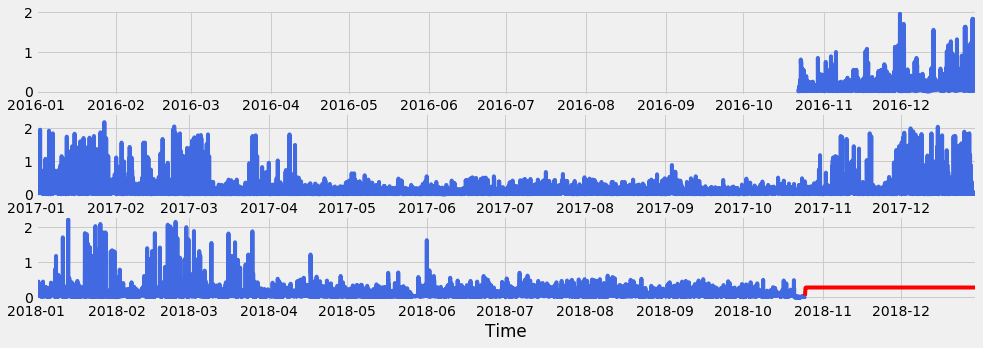

In [207]:
# plot electricity consumption for different years
YEAR = 2018  # 2016 (partial), 2017, 2018
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(15, 5))
ax1.plot(features_and_target.loc[features_and_target['year'] == 2016, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2016, 'USAGE'], color='royalblue')
ax2.plot(features_and_target.loc[features_and_target['year'] == 2017, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2017, 'USAGE'], color='royalblue')
ax3.plot(features_and_target.loc[features_and_target['year'] == 2018, 'DateTime'],
         features_and_target.loc[features_and_target['year'] == 2018, 'USAGE'], color='royalblue')
ax3.plot(forecast_df.loc[forecast_df['year'] == 2018, 'DateTime'],
         forecast_df.loc[forecast_df['year'] == 2018, 'USAGE'], color='red')
ax1.set_xlim(left=pd.datetime(2016,1,1), right=pd.datetime(2016,12,30))
ax2.set_xlim(left=pd.datetime(2017,1,1), right=pd.datetime(2017,12,30))
ax3.set_xlim(left=pd.datetime(2018,1,1), right=pd.datetime(2018,12,30))
# ax2.set_ylabel('USAGE_kW')
ax3.set_xlabel('Time')
plt.show()

In [37]:
# predictoin (in sample)
y_pred = lstm_model.predict(X_test)

lstm_score = r2_score(y_test,y_pred)
print("R2 Score of LSTM model = ",lstm_score)
# R2 Score of LSTM model =  0.7420690462998017

R2 Score of LSTM model =  0.7420690462998017


In [0]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
